**Описание исследования**

---

**Цель исследования**  
Разработать модель, способную автоматически определять различные типы мусора на сортировочном конвейере мусороперерабатывающего завода.

---

**Исходные данные**

- **images**  
  Папка, содержащая 9000 изображений. Каждое изображение представляет собой кадр с конвейерной ленты, на котором видны отходы различных типов.

- **train.csv**:  
  CSV-файл, содержащий разметку для обучения модели. Каждая строка включает:
  - `file_name`: имя файла
  - `bbox`: рамка в формате [x_left, y_top, width, height]
  - `category_id`: класс объекта, присутствующего на изображении

- **test.csv**:  
  Файл, содержащий имена изображений для тестирования. Эти изображения необходимо классифицировать с помощью разработанных моделей.

- **sample_submission.csv**:  
  Пример файла для отправки решений:
  - `file_name`: имя файла
  - `bbox`: список списков, каждый объект в формате [class, confidence, x_left, y_top, width, height]

---

**Данное исследование разделим на три этапа:**

1. Исследовательский анализ данных
2. Обучение модели
3. Анализ обученной модели


# Библиотеки и окружение

In [ ]:
!pip install -U ultralytics -q

In [ ]:
import os
import cv2
import yaml
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from torch import tensor
from torchmetrics.detection import MeanAveragePrecision
import cv2

In [ ]:
import matplotlib.pyplot as plt
import ast

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
df_test = pd.read_csv('/kaggle/input/waste-detection/test.csv')
data = pd.read_csv('/kaggle/input/waste-detection/train.csv')
df_sample = pd.read_csv('/kaggle/input/waste-detection/sample_submission.csv')

In [ ]:
display(df_test.head())
display(data.head())
display(df_sample.head())

,file_name
0,000003.jpg
1,000006.jpg
2,000013.jpg
3,000016.jpg
4,000019.jpg


,file_name,bbox,category_id
0,000001.jpg,"[840.0, 0.0, 176.0, 124.0]",4.0
1,000001.jpg,"[612.0, 306.0, 383.0, 397.0]",2.0
2,000001.jpg,"[990.92, 551.0, 105.00000000000011, 186.0]",4.0
3,000002.jpg,"[1000.0, 614.0, 98.0, 178.0]",4.0
4,000002.jpg,"[605.0, 358.0, 402.0, 409.0]",2.0


,file_name,bbox
0,000003.jpg,"[[5.0, 0.64, 536.1, 76.56, 834.52, 890.82], [5..."
1,000006.jpg,"[[4.0, 0.91, 397.68, 3.2, 218.05, 970.42], [4...."
2,000013.jpg,[]
3,000016.jpg,"[[8.0, 0.89, 587.89, 771.75, 636.26, 337.43], ..."
4,000019.jpg,"[[7.0, 0.68, 75.08, 220.41, 982.22, 794.76], [..."


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  2999 non-null   object
dtypes: object(1)
memory usage: 23.6+ KB


In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  2999 non-null   object
 1   bbox       2999 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


Тестовый датасет и образец для предсказания совпадают по количеству строк

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32265 entries, 0 to 32264
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    32265 non-null  object 
 1   bbox         32148 non-null  object 
 2   category_id  32148 non-null  float64
dtypes: float64(1), object(2)
memory usage: 756.3+ KB


Пропуски в данных, проанализируем.

In [ ]:
data.isna().sum()

file_name        0
bbox           117
category_id    117
dtype: int64

В обоих столбцах по 117 строк. Проверим совпадают ли они.

In [ ]:
empty_values = data.query('bbox != bbox and category_id != category_id')
print(len(empty_values))

117


In [ ]:
empty_values.head()

,file_name,bbox,category_id
1904,000593.jpg,NaN,NaN
1905,000594.jpg,NaN,NaN
1906,000596.jpg,NaN,NaN
4685,001514.jpg,NaN,NaN
4686,001515.jpg,NaN,NaN


In [ ]:
empty_file_names = empty_values['file_name'].unique()

Строки совпадают, удалим 117 строк пропущенных значений. Для перепроверки сохраним список.

In [ ]:
data = data.dropna()

## Исследовательский анализ данных

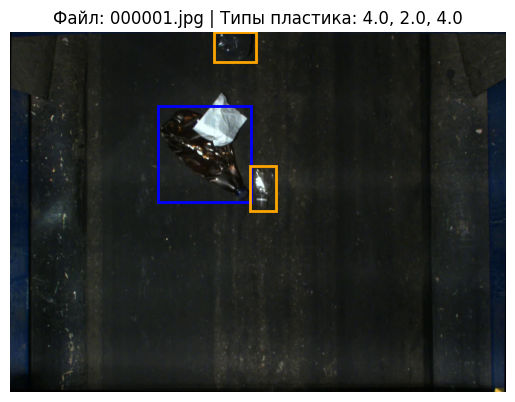

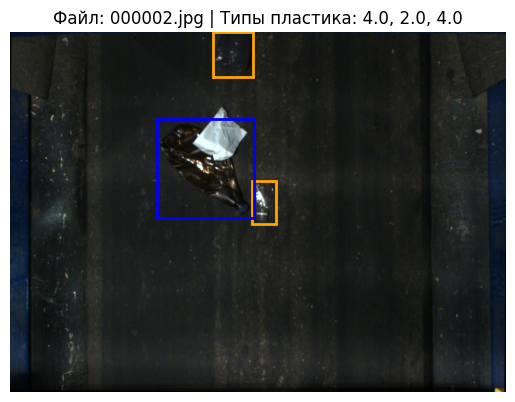

In [ ]:

# Определяем цвета для 15 классов
colors = {
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'orange',
    5: 'purple',
    6: 'cyan',
    7: 'magenta',
    8: 'yellow',
    9: 'brown',
    10: 'pink',
    11: 'gray',
    12: 'lightblue',
    13: 'lightgreen',
    14: 'lightcoral',
    15: 'gold',
}

def check(file_names):
    for file_name in file_names:
        # Находим все индексы, соответствующие file_name
        indices = data[data.file_name == file_name].index

        if not indices.empty:
            category_ids = []  # Список для хранения category_id для текущего file_name

            # Создаем изображение
            image = Image.open('/kaggle/input/waste-detection/images/' + file_name)
            array = np.array(image)

            for idx in indices:
                k = data.category_id[idx]
                category_ids.append(k)  # Добавляем текущий category_id в список

                # Извлекаем bbox и преобразуем строку в список
                bbox_str = data.bbox[idx]
                bbox = ast.literal_eval(bbox_str)

                # Извлекаем координаты и размеры
                xmin = float(bbox[0])
                ymin = float(bbox[1])
                width = float(bbox[2])
                height = float(bbox[3])

                # Получаем цвет для текущего класса
                color = colors.get(k, 'black')  # Черный по умолчанию, если класс не найден

                # Рисуем bbox на изображении
                plt.gca().add_patch(plt.Rectangle((xmin, ymin), width, height,
                                                   edgecolor=color, facecolor='none', linewidth=2))

            # Формируем строку для заголовка
            category_ids_str = ', '.join(map(str, category_ids))
            plt.title('Файл: {} | Типы пластика: {}'.format(file_name, category_ids_str))
            plt.imshow(array)
            plt.axis('off')  # Отключаем оси
            plt.show()
        else:
            print(f"Файл {file_name} не найден в данных.")


check(['000001.jpg', '000002.jpg'])

Теперь проверим было ли в пропусках в данных другие обозначения классов на изображениях.

In [ ]:
check(empty_file_names)

Файл 000593.jpg не найден в данных.
Файл 000594.jpg не найден в данных.
Файл 000596.jpg не найден в данных.
Файл 001514.jpg не найден в данных.
Файл 001515.jpg не найден в данных.
Файл 001517.jpg не найден в данных.
Файл 001518.jpg не найден в данных.
Файл 001520.jpg не найден в данных.
Файл 001521.jpg не найден в данных.
Файл 001523.jpg не найден в данных.
Файл 001524.jpg не найден в данных.
Файл 001526.jpg не найден в данных.
Файл 001527.jpg не найден в данных.
Файл 001529.jpg не найден в данных.
Файл 001530.jpg не найден в данных.
Файл 001532.jpg не найден в данных.
Файл 001533.jpg не найден в данных.
Файл 001535.jpg не найден в данных.
Файл 001586.jpg не найден в данных.
Файл 001587.jpg не найден в данных.
Файл 001589.jpg не найден в данных.
Файл 001590.jpg не найден в данных.
Файл 001592.jpg не найден в данных.
Файл 001593.jpg не найден в данных.
Файл 001595.jpg не найден в данных.
Файл 001596.jpg не найден в данных.
Файл 001634.jpg не найден в данных.
Файл 001635.jpg не найден в 

Количество экземпляров для каждого класса:
category_id
2.0     7310
1.0     4747
13.0    4553
4.0     3780
7.0     2530
14.0    2278
10.0    2123
15.0    1032
5.0      909
3.0      848
9.0      653
6.0      495
11.0     374
8.0      364
12.0     152
Name: count, dtype: int64


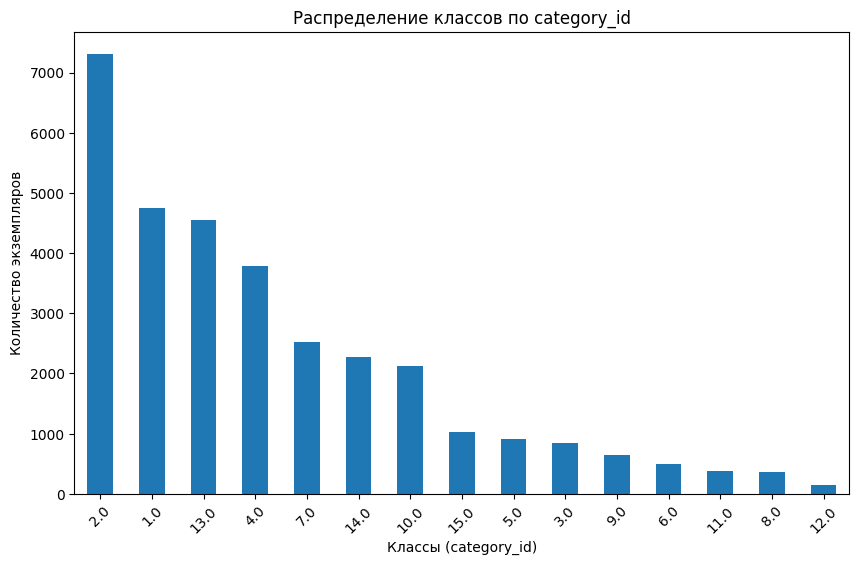

In [ ]:

class_counts = data['category_id'].value_counts()

print('Количество экземпляров для каждого класса:')
print(class_counts)

# Визуализация распределения классов
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Распределение классов по category_id')
plt.xlabel('Классы (category_id)')
plt.ylabel('Количество экземпляров')
plt.xticks(rotation=45)
plt.show()


Классы:
- Not plastic
- PET (transparent) (dark blue)
- PET (transparent) (blue)
- PET (flacon)
- PET (black)
- PND (household chemicals)
- PET (sticker)
- PND packet

 представлены в меньших количествах.

  При дальнейших тренировках модели рекомендуется предоставить больше данных по этим классам.

### Выбор и обучение модели.


При выборе модели компьютерного зрения я проанализировала опыт Нидерландов в вопросах сортировки мусора и управления отходами и остановилась на модели YOLO (You Only Look Once).

**Основные преимущества:**

1. **Эффективность в реальных условиях**  
   В Нидерландах YOLO внедрили на заводах по переработке мусора. Модель точно распознаёт разные типы отходов, что делает её полезной в реальных условиях.

2. **Высокая точность распознавания**  
   Предприятия, использующие YOLO, заметили значительное снижение количества ошибок, что помогает лучше перерабатывать материалы.

3. **Скорость обработки**  
   Скорость обработки изображений важна для автоматизированных систем сортировки. YOLO может работать в реальном времени, быстро реагируя на поток отходов и уменьшая задержки в сортировке.

4. **Адаптивность к различным типам отходов**  
   В Нидерландах много разных типов отходов, и YOLO смогла адаптироваться к этим условиям. Модель легко обучается на конкретных данных, что позволяет ей распознавать как стандартные, так и необычные виды мусора.

Таким образом, я выбрала YOLO для задач компьютерного зрения, основываясь на успешном опыте Нидерландов. Высокая точность, скорость обработки, адаптивность и поддержка устойчивого развития делают YOLO идеальным решением для автоматизации сортировки мусора и управления отходами.

Подготовка датасета и создание yaml-файла.

In [ ]:
def convert_to_yolo_format(images_folder, annotations_csv, output_folder, train_ratio=0.8):
    # Создаем выходные папки
    os.makedirs(os.path.join(output_folder, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'labels', 'val'), exist_ok=True)

    # Получаем уникальные классы
    data = pd.read_csv(annotations_csv)
    data = data.dropna()
    classes = data['category_id'].unique()
    class_dict = {cls: idx for idx, cls in enumerate(classes)}

    # Разбивка по уникальным именам файлов
    unique_filenames = data['file_name'].unique()
    train_filenames, val_filenames = train_test_split(unique_filenames, test_size=(1 - train_ratio), random_state=42)


    def copy_images(filenames, img_folder):
        for filename in filenames:
            img_path = os.path.join(images_folder, filename)

            # Проверяем
            if not os.path.exists(img_path):
                print(f"Изображение {filename} не найдено.")
                continue

            # Копируем изображение в соответствующую папку
            dest_img_path = os.path.join(output_folder, 'images', img_folder, filename)
            shutil.copy(img_path, dest_img_path)


    copy_images(train_filenames, 'train')
    copy_images(val_filenames, 'val')


    def create_annotations(filenames, label_folder):
        for filename in filenames:
            group = data[data['file_name'] == filename]


            img_path = os.path.join(output_folder, 'images', label_folder, filename)
            img = cv2.imread(img_path)
            height, width, _ = img.shape


            annotation_file = os.path.join(output_folder, 'labels', label_folder, filename.replace('.jpg', '.txt'))
            with open(annotation_file, 'w') as f:
                for index, row in group.iterrows():
                    bbox = row['bbox']
                    category_id = row['category_id']


                    if isinstance(bbox, str):
                        bbox = eval(bbox)


                    if not isinstance(bbox, list):
                        print(f"Ошибка: bbox для {filename} не является списком: {bbox}")
                        continue


                    try:
                        bbox = [float(coord) for coord in bbox]
                    except ValueError as e:
                        print(f"Ошибка преобразования bbox для {filename}: {e}")
                        continue


                    xmin = bbox[0]
                    ymin = bbox[1]
                    bbox_width = bbox[2]
                    bbox_height = bbox[3]
                    xmax = xmin + bbox_width
                    ymax = ymin + bbox_height


                    x_center = (xmin + xmax) / 2 / width
                    y_center = (ymin + ymax) / 2 / height
                    bbox_width /= width
                    bbox_height /= height


                    f.write(f"{category_id - 1} {x_center} {y_center} {bbox_width} {bbox_height}\n")


    create_annotations(train_filenames, 'train')
    create_annotations(val_filenames, 'val')

    print("Конвертация и разбивка завершены!")


convert_to_yolo_format(
    images_folder='/kaggle/input/waste-detection/images',
    annotations_csv='/kaggle/input/waste-detection/train.csv',
    output_folder='/kaggle/working/yolo_dataset',
    train_ratio=0.8
)

Конвертация и разбивка завершены!


In [ ]:

# Создание yaml
df = {
    'train': '/kaggle/input/yolo-sort-grouped-o/yolo_dataset/images/train',
    'val': '/kaggle/input/yolo-sort-grouped-o/yolo_dataset/images/val',
    'names': [
        '0.0', '1.0', '2.0', '3.0', '4.0',
        '5.0', '6.0', '7.0', '8.0', '9.0',
        '10.0', '11.0', '12.0', '13.0', '14.0'
    ],
    'nc': 15
}

destination_file_path = '/kaggle/working/data_yolo.yaml'
with open(destination_file_path, 'w') as file:
    yaml.dump(df, file, default_flow_style=False, sort_keys=False)

print("Файл data_yolo.yaml успешно создан!")


Файл data_yolo.yaml успешно создан!


In [ ]:
def zip_yolo_dataset(output_folder):
    # Путь к папке yolo_dataset
    yolo_dataset_path = os.path.join(output_folder, 'yolo_dataset')

    # Путь к ZIP-файлу
    zip_file_path = os.path.join(output_folder, 'yolo_dataset.zip')

    # Создание ZIP-архива
    shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', yolo_dataset_path)

    print(f"ZIP-архив создан: {zip_file_path}")


zip_yolo_dataset(output_folder='/kaggle/working')

ZIP-архив создан: /kaggle/working/yolo_dataset.zip


Данные подготовлены, далее тренировка моделей.
Версии YOLO 5n и 8 уступали в точности и производительности по сравнению с предобученными версиями YOLO11

| Model         | Size (pixels) | mAPval 50-95 | Speed CPU ONNX (ms) | Speed A100 TensorRT (ms) | Params (M) | FLOPs (B) |
|---------------|---------------|--------------|----------------------|---------------------------|------------|-----------|
| yolov5nu.pt   | 640           | 34.3         | 73.6                 | 1.06                      | 2.6        | 7.7       |
| yolov5su.pt   | 640           | 43.0         | 120.7                | 1.27                      | 9.1        | 24.0      |
| yolov5mu.pt   | 640           | 49.0         | 233.9                | 1.86                      | 25.1       | 64.2      |
| yolov5lu.pt   | 640           | 52.2         | 408.4                | 2.50                      | 53.2       | 135.0     |
| yolov5xu.pt   | 640           | 53.2         | 763.2                | 3.81                      | 97.2       | 246.4     |
| yolov5n6u.pt  | 1280          | 42.1         | 211.0                | 1.83                      | 4.3        | 7.8       |
| yolov5s6u.pt  | 1280          | 48.6         | 422.6                | 2.34                      | 15.3       | 24.6      |
| yolov5m6u.pt  | 1280          | 53.6         | 810.9                | 4.36                      | 41.2       | 65.7      |
| yolov5l6u.pt  | 1280          | 55.7         | 1470.9               | 5.47                      | 86.1       | 137.4     |
| yolov5x6u.pt  | 1280          | 56.8         | 2436.5               | 8.98                      | 155.4      | 250.7     |


| Model   | Size (pixels) | mAPval 50-95 | Speed CPU ONNX (ms) | Speed A100 TensorRT (ms) | Params (M) | FLOPs (B) |
|---------|---------------|--------------|----------------------|---------------------------|------------|-----------|
| YOLOv8n | 640           | 37.3         | 80.4                 | 0.99                      | 3.2        | 8.7       |
| YOLOv8s | 640           | 44.9         | 128.4                | 1.20                      | 11.2       | 28.6      |
| YOLOv8m | 640           | 50.2         | 234.7                | 1.83                      | 25.9       | 78.9      |
| YOLOv8l | 640           | 52.9         | 375.2                | 2.39                      | 43.7       | 165.2     |
| YOLOv8x | 640           | 53.9         | 479.1                | 3.53                      | 68.2       | 257.8     |


| Model    | Size (pixels) | mAPval 50-95 | Speed CPU ONNX (ms) | Speed T4 TensorRT10 (ms) | Params (M) | FLOPs (B) |
|----------|---------------|--------------|----------------------|---------------------------|------------|-----------|
| YOLO11n  | 640           | 39.5         | 56.1 ± 0.8           | 1.5 ± 0.0                 | 2.6        | 6.5       |
| YOLO11s  | 640           | 47.0         | 90.0 ± 1.2           | 2.5 ± 0.0                 | 9.4        | 21.5      |
| YOLO11m  | 640           | 51.5         | 183.2 ± 2.0          | 4.7 ± 0.1                 | 20.1       | 68.0      |
| YOLO11l  | 640           | 53.4         | 238.6 ± 1.4          | 6.2 ± 0.1                 | 25.3       | 86.9      |
| YOLO11x  | 640           | 54.7         | 462.8 ± 6.7          | 11.3 ± 0.2                | 56.9       | 194.9     |


Была произведена тренировка моделей YOLO 11n, 11m, 11l, 11x. Тренировки проводились по 100 эпох с параметром batch=8 и размером изображения 608 пикселей.
Наибольшей точность при сравнительно быстром времени обучения достигла модель YOLO11l. Модель 11х также показывала хорошие результаты. При дальнейшей работе рекомендуется протестировать применить инструмент tune() для тонкой настройки модели.

Результаты валидации модели YOLO11x:

In [ ]:
model_15 = YOLO("/kaggle/input/sort-renue/runs/detect/train/weights/best.pt")


preds = model_15.val(save_json=True, plots=True,project='mod_15',name='mod_15' )

Ultralytics 8.3.39 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11x summary (fused): 464 layers, 56,844,349 parameters, 0 gradients, 194.5 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 16.1MB/s]
val: Scanning /kaggle/input/yolo-sort-grouped-o/yolo_dataset/labels/val... 1177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1177/1177 [00:11<00:00, 106.12it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/yolo-sort-grouped-o/yolo_dataset/labels is not writeable, cache not saved.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:55<00:00,  1.34it/s]


                   all       1177       6191      0.975       0.92      0.959      0.874
                   0.0        666        913      0.985      0.941      0.969      0.881
                   1.0        809       1433      0.987      0.953      0.981      0.892
                   2.0        153        160      0.973       0.91      0.941      0.848
                   3.0        530        724      0.979       0.91      0.961      0.864
                   4.0        148        160      0.987      0.912      0.959      0.889
                   5.0         92         95      0.979      0.926      0.967       0.87
                   6.0        410        496      0.983      0.928      0.963      0.894
                   7.0         68         71       0.97      0.925      0.952      0.847
                   8.0        110        125      0.989      0.936      0.965       0.89
                   9.0        353        438      0.985      0.899      0.962      0.896
                  10.


Также при первом преобразовании датасета была допущена ошибка в коде, о которой стоит упомянуть.


Я начала создавать файлы train.txt и val.txt, в которых должны были храниться пути к изображениям и их аннотации.
Для этого я перебрала изображения в папке train и записала их пути в train.txt. Аналогично, я сделала для папки val, записав пути в val.txt.


В процессе записи я столкнулась с проблемой: некоторые аннотации были неполными, и я не смогла завершить запись TXT файлов полностью.
В результате в train.txt и val.txt оказались только части изображений, что могло повлиять на качество обучения модели.


После создания TXT файлов я провела обработку данных, чтобы убедиться, что они готовы к использованию в модели YOLO.
Я проверила, что все необходимые пути и аннотации были корректны, даже если запись была частичной.



В итоге я получила готовый датасет, который могла использовать для обучения. После тренировки модели на 100 эпохах я обнаружила ошибку в записи датасета, но поскольку показатели модели были хорошими я использовала лучшую модель для обучения уже на новом, правильно сформированном датасете, на 40 эпохах. Результаты валидации хорошие. Если эффективно доработать такую методику формирования данных такой подход сможет быть частью процесса создания и улучшения данных.

In [ ]:
model_b3 = YOLO("/kaggle/input/sort-renue/runs/detect/train2/weights/best.pt")

# Запуск предсказания на изображении 'bus.jpg'
preds_b3 = model_b3.val(save_json=True, plots=True,project='b3',name='b3' )

Ultralytics 8.3.39 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11x summary (fused): 464 layers, 56,844,349 parameters, 0 gradients, 194.5 GFLOPs


val: Scanning /kaggle/input/yolo-sort-grouped-o/yolo_dataset/labels/val... 1177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1177/1177 [00:02<00:00, 488.43it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/yolo-sort-grouped-o/yolo_dataset/labels is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [01:00<00:00,  1.21it/s]


                   all       1177       6191      0.978      0.897      0.957      0.866
                   0.0        666        913      0.985      0.938       0.97      0.874
                   1.0        809       1433      0.988      0.943      0.978      0.886
                   2.0        153        160      0.979      0.891      0.945      0.851
                   3.0        530        724       0.98      0.893      0.957      0.851
                   4.0        148        160      0.993      0.905      0.952       0.88
                   5.0         92         95      0.958      0.905      0.964       0.87
                   6.0        410        496      0.985      0.898      0.962      0.885
                   7.0         68         71      0.968      0.859      0.941      0.828
                   8.0        110        125      0.983      0.913      0.952      0.882
                   9.0        353        438      0.985      0.874      0.954      0.876
                  10.

Тем не менее такой подход следует более детально проанализировать.

Итоговая модель YOLO11l, получившая лучшие результаты:

In [ ]:
model = YOLO("yolo11l.pt")
model.train(data="/kaggle/input/data-yolo/data_yolo.yaml",
            epochs=45,
            imgsz=1024,
            name="l11_one",
            plots=False,
            val=True,
            patience=5,
            batch=8)

100%|██████████| 49.0M/49.0M [00:00<00:00, 261MB/s]


Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/input/data-yolo/data_yolo.yaml, epochs=45, time=None, patience=5, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=l11_one, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]
2024-12-03 09:14:55,827	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-03 09:14:56,288	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/yolo-sort-grouped-o/yolo_dataset/labels/train... 4707 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4707/4707 [00:33<00:00, 139.91it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/yolo-sort-grouped-o/yolo_dataset/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/yolo-sort-grouped-o/yolo_dataset/labels/val... 1177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1177/1177 [00:10<00:00, 110.34it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/yolo-sort-grouped-o/yolo_dataset/labels is not writeable, cache not saved.
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/l11_one
Starting training for 45 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/45        15G     0.7967      1.474      1.094         30       1024: 100%|██████████| 589/589 [11:29<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:37<00:00,  1.95it/s]

                   all       1177       6191      0.558      0.588      0.619      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/45      14.8G     0.8001     0.9909      1.097         40       1024: 100%|██████████| 589/589 [11:21<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:37<00:00,  1.96it/s]


                   all       1177       6191      0.676      0.625      0.652      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/45      14.4G     0.7799     0.9203      1.083         35       1024: 100%|██████████| 589/589 [11:19<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.01it/s]

                   all       1177       6191      0.732       0.65      0.714      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/45      14.4G     0.7637     0.8443      1.074         25       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.01it/s]

                   all       1177       6191      0.763      0.726      0.787      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/45      14.4G     0.7434     0.7687      1.065         22       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191       0.82      0.764      0.836      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/45      14.3G     0.7246     0.6965       1.05         37       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.749      0.752      0.824      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/45      14.5G     0.7104     0.6582      1.045         11       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.02it/s]

                   all       1177       6191      0.875      0.779      0.884      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/45      14.5G     0.6909      0.608      1.032         33       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.914      0.815      0.904      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/45      14.3G     0.6844     0.5845      1.026         43       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.929      0.836      0.923      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/45      14.9G     0.6737      0.556       1.02         38       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.02it/s]

                   all       1177       6191      0.939      0.839      0.923      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/45      14.4G     0.6664     0.5353      1.015         25       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.02it/s]

                   all       1177       6191       0.94      0.851      0.924      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/45      14.4G     0.6594     0.5177      1.013         37       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.947      0.861      0.933      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/45      14.4G     0.6488     0.4958      1.009         26       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.02it/s]

                   all       1177       6191       0.95      0.876      0.934       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/45      14.3G     0.6483     0.4995      1.011         30       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.02it/s]

                   all       1177       6191      0.952      0.869      0.935      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/45      14.4G     0.6369     0.4718      1.001         34       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.956       0.88      0.938       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/45      14.4G     0.6247     0.4584     0.9958         23       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191       0.96      0.884      0.942      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/45      14.3G      0.616     0.4462     0.9934         21       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.962      0.886      0.944      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/45      14.9G     0.6122     0.4365       0.99         18       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.961      0.902      0.948      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/45      14.4G     0.6052     0.4321     0.9875         41       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.01it/s]

                   all       1177       6191      0.969       0.88      0.945      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/45      14.4G     0.6009     0.4237     0.9875         42       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.963      0.896      0.948      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/45      14.3G     0.5953     0.4169     0.9829         35       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.977      0.894       0.95       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/45      14.3G     0.5918     0.4111     0.9838         17       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.02it/s]

                   all       1177       6191      0.974      0.896      0.951      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/45      14.3G     0.5781     0.3975     0.9733         32       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.969      0.901      0.949      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/45      14.3G     0.5712     0.3937     0.9724         26       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.973      0.895      0.954      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/45      14.3G     0.5636     0.3761     0.9667         17       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.01it/s]

                   all       1177       6191      0.963      0.911      0.953      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/45      14.8G     0.5681     0.3789     0.9721         38       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.978      0.905      0.957      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/45      14.3G     0.5571     0.3692     0.9659         16       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.02it/s]

                   all       1177       6191      0.982      0.899      0.956      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/45      14.3G     0.5449     0.3599     0.9558         20       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.966       0.91      0.954      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/45      14.3G     0.5479     0.3579     0.9614         27       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.979      0.905      0.957      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/45      14.3G      0.535     0.3504     0.9501         17       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.978      0.913       0.96      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/45      14.4G     0.5314     0.3471     0.9494         41       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.983      0.902      0.958      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/45      14.3G     0.5308     0.3458     0.9512         33       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.984      0.908      0.959      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/45      14.4G     0.5173     0.3338     0.9454          9       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191       0.98      0.916      0.962      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/45      14.9G     0.5156     0.3317      0.946         20       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191       0.98      0.914      0.961      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/45      14.4G      0.514     0.3285      0.945         20       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.02it/s]

                   all       1177       6191      0.984      0.914      0.962      0.875


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/45      14.4G     0.4596     0.2748     0.9232         17       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.984      0.912      0.959      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/45      14.4G     0.4489     0.2627     0.9132         18       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.03it/s]

                   all       1177       6191      0.978      0.911      0.959      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/45      14.3G      0.442     0.2562     0.9093         15       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.02it/s]

                   all       1177       6191      0.974      0.916      0.959      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/45      14.4G     0.4355     0.2513     0.9081         11       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.02it/s]

                   all       1177       6191      0.981      0.915       0.96      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/45      14.4G     0.4285     0.2465     0.9037         16       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.02it/s]

                   all       1177       6191      0.977      0.919       0.96      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/45      14.4G     0.4235      0.242     0.9018         18       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.02it/s]

                   all       1177       6191       0.98      0.919      0.962      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/45      14.9G      0.419     0.2391     0.8988         20       1024: 100%|██████████| 589/589 [11:18<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.01it/s]

                   all       1177       6191      0.984       0.92       0.96      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/45      14.5G     0.4118     0.2365     0.8944         20       1024: 100%|██████████| 589/589 [11:19<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:37<00:00,  1.98it/s]

                   all       1177       6191      0.981      0.923      0.961      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/45      14.4G     0.4063     0.2327     0.8931         16       1024: 100%|██████████| 589/589 [11:19<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:37<00:00,  1.96it/s]

                   all       1177       6191      0.982      0.922      0.962      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/45      14.4G     0.4017     0.2293     0.8893         19       1024: 100%|██████████| 589/589 [11:19<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:37<00:00,  1.96it/s]

                   all       1177       6191      0.978      0.929      0.962      0.883



45 epochs completed in 8.976 hours.
Optimizer stripped from runs/detect/l11_one/weights/last.pt, 51.3MB
Optimizer stripped from runs/detect/l11_one/weights/best.pt, 51.3MB

Validating runs/detect/l11_one/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11l summary (fused): 464 layers, 25,290,877 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:36<00:00,  2.01it/s]

                   all       1177       6191      0.978      0.929      0.962      0.883
                   0.0        666        913       0.99      0.946      0.974      0.893
                   1.0        809       1433      0.982      0.959      0.983      0.901
                   2.0        153        160      0.967        0.9      0.942      0.857
                   3.0        530        724       0.96      0.924      0.964      0.867
                   4.0        148        160      0.992      0.925      0.951      0.889
                   5.0         92         95      0.978      0.916      0.968      0.888
                   6.0        410        496      0.978      0.944      0.966      0.897
                   7.0         68         71      0.992       0.93      0.948      0.855
                   8.0        110        125      0.979      0.928      0.957      0.897
                   9.0        353        438      0.974      0.925      0.965      0.901
                  10.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7de3085a0580>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,   

Метрики на валидации:

| Class | Images | Instances | Box(P) | Box(R) | mAP50 | mAP50-95 |
|-------|--------|-----------|--------|--------|-------|----------|
| all   | 1177   | 6191      | 0.978  | 0.929  | 0.962 | 0.883    |
| 0.0   | 666    | 913       | 0.990  | 0.946  | 0.974 | 0.893    |
| 1.0   | 809    | 1433      | 0.982  | 0.959  | 0.983 | 0.901    |
| 2.0   | 153    | 160       | 0.967  | 0.900  | 0.942 | 0.857    |
| 3.0   | 530    | 724       | 0.960  | 0.924  | 0.964 | 0.867    |
| 4.0   | 148    | 160       | 0.992  | 0.925  | 0.951 | 0.889    |
| 5.0   | 92     | 95        | 0.978  | 0.916  | 0.968 | 0.888    |
| 6.0   | 410    | 496       | 0.978  | 0.944  | 0.966 | 0.897    |
| 7.0   | 68     | 71        | 0.992  | 0.930  | 0.948 | 0.855    |
| 8.0   | 110    | 125       | 0.979  | 0.928  | 0.957 | 0.897    |
| 9.0   | 353    | 438       | 0.974  | 0.925  | 0.965 | 0.901    |
| 10.0  | 75     | 77        | 0.971  | 0.935  | 0.963 | 0.878    |
| 11.0  | 30     | 30        | 1.000  | 0.918  | 0.963 | 0.905    |
| 12.0  | 583    | 849       | 0.971  | 0.923  | 0.969 | 0.884    |
| 13.0  | 336    | 449       | 0.959  | 0.940  | 0.965 | 0.892    |
| 14.0  | 161    | 171       | 0.971  | 0.918  | 0.953 | 0.842    |

**Speed:** 0.3ms preprocess, 27.5ms inference, 0.0ms loss, 0.9ms postprocess per image


**mAP метрика на тестовой выборке 0.85987.**


Такие показатели говорят о том, что модель не переобучилась.

 Но показатель недостаточно высокий, модель необходимо дообучать на новых данных и использовать методы настройки гиперпараметров библиотеки YOLO, такие как tune().

# Выводы:

Данные проанализированы. Выявлены пропуски в данных: 117 строк, по результатам проверки для заявленного списка изображений с пропусками отсутствуют все записи.

На основе исследовательского анализа выделены минорные классы, которые имеют значительно меньшее количество примеров по сравнению с другими классами.


| Класс                               | Количество |
|-------------------------------------|------------|
| Not plastic                         | 1032       |
| PET (transparent) (dark blue)      | 909        |
| PET (transparent) (blue)           | 848        |
| PET (flacon)                       | 653        |
| PET (black)                        | 495        |
| PND (household chemicals)          | 374        |
| PET (sticker)                      | 364        |
| PND packet                         | 152        |


При дальнейших тренировках модели рекомендуется предоставить больше данных по этим классам.

По результатам подбора и тренировок моделей выделена лучшая модель **YOLO11l**, с показателями **0.85987.** на тестовой выборке

При дальнейшей работе будут задействованы такие инструменты усовершенствования моделей, как:

- **Аугментация данных**

    Применение различных методов для увеличения объема обучающего набора данных.
- **Взвешивание классов**

    Настройка весов классов в функции потерь для улучшения работы с минорными классами.
- **Синтетические данные**

    Генерация новых примеров с помощью методов, таких как SMOTE.    
- **Оптимизация гиперпараметров**

    Настройки гиперпараметров методом model.tune().
- **Использование ансамблей**

    Комбинирование нескольких моделей для улучшения общей производительности.
